**Groups:**
+ *ecoli_HOGs_fullid_all* - all hierarchical orthologous groups (HOGs) with full id (**22356** groups)

    Command: **python extract_og.py -i ecoli_full_data/* -o ecoli_HOGs_fullid_all -g HOG --full_HOG --incl-nonPP**
    
+ *ecoli_HOGs_fullid_PP* - hierarchical orthologous groups (HOGs) with full id including only those containing at least 1 protein with polyproline motif (**7296** groups)

    Command: **python extract_og.py -i ecoli_full_data/* -o ecoli_HOGs_fullid_PP -g HOG --full_HOG**
    
+ *ecoli_HOGs_partid_all* - hierarchical orthologous groups (HOGs) with partial id including only those containing at least 1 protein with polyproline motif (**7700** groups)

    Command: **python extract_og.py -i ecoli_full_data/* -o ecoli_HOGs_partid_all -g HOG --incl-nonPP**
    
+ *ecoli_HOGs_partid_PP* - all hierarchical orthologous groups (HOGs) with partial id (less similarity among proteins in group, paralogs are present) (**2736** groups)

    Command: **python extract_og.py -i ecoli_full_data/* -o ecoli_HOGs_partid_PP -g HOG**
    
+ *ecoli_OMAs_all* - all OMA groups (**12441** groups)

    Command: **python extract_og.py -i ecoli_full_data/* -o ecoli_OMAs_all -g OMA --incl-nonPP --oma-groups oma-groups.txt**
    
+ *ecoli_OMAs_PP* - OMA groups  including only those containing at least 1 protein with polyproline motif (**4437** groups)

    Command: **python extract_og.py -i ecoli_full_data/* -o ecoli_OMAs_PP -g OMA --oma-groups oma-groups.txt**

In [1]:
import re
from collections import defaultdict
from itertools import combinations
from statistics import mean
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from tqdm import tqdm_notebook


pd.set_option("display.max_rows", 100)

## Parsing

In [2]:
# A number of different groups can be obtained by running extract_og.py
# Hovewer only ecoli_OMAs_PP is used in this notebook
# It is possible to specify any of these groups as alternatives
groups_list = ["ecoli_HOGs_fullid_all", "ecoli_HOGs_fullid_PP",
               "ecoli_HOGs_partid_all", "ecoli_HOGs_partid_PP",
               "ecoli_OMAs_all", "ecoli_OMAs_PP"]


def get_group_data(path_to_dir):
    """Parse information stored in fasta headers of extract_of.py output.
    It takes path to output dir as argument and returns 3 data frames:
        1. data_groups (3 fields: protein id, taxonimic id and orthologous group)
        2. data_motifs (3 fields: protein id, motif strength and motif sequence)
        3. data_groups (2 fields: protein id and protein length)"""
    data_groups = defaultdict(list)
    data_motifs = defaultdict(list)
    data_protein = defaultdict(list)
    for filename in os.listdir(path_to_dir):
        parser = SeqIO.parse(os.path.join(path_to_dir, filename), "fasta")
        for p_idx, r in enumerate(parser):
            try:
                prot_id, taxid, og, motifs = r.description.split(" | ")
            except ValueError:   # Sequence without polyproline motifs
                (prot_id, taxid, og), motifs = r.description.split(" | "), "NNNNN:0:0:N"

            motifs = motifs.split()
            data_groups["prot_id"].append(prot_id.strip("| "))
            data_groups["taxid"].append(taxid.strip("| "))
            data_groups["og"].append(og.strip("| "))
            data_protein["prot_id"].append(prot_id.strip("| "))
            data_protein["length"].append(len(r.seq))
            for m_idx, motif in enumerate(motifs):
                seq, _, _, strength = motif.split(":")
                data_motifs["prot_id"].append(prot_id.strip("| "))
                data_motifs["strength"].append(strength.strip("| "))
                data_motifs["seq"].append(seq.strip("| "))
    data_groups = pd.DataFrame(data_groups)
    data_motifs = pd.DataFrame(data_motifs)
    data_protein = pd.DataFrame(data_protein)
    return data_groups, data_motifs, data_protein

## Group composition

ecoli_OMAs_PP
Total number of groups:  4437
Groups with 1 protein - 642
Groups with 43 proteins (core proteome) - 777
Groups with < 43 proteins (accessory proteome) - 3660
Groups with > 43 proteins (paralogs included) - 38
Total number of paralogs - 517
Median of paralogs - 0.0
Mean of paralogs - 0.11652017128690556



Text(0.5, 1.0, 'ecoli_OMAs_PP')

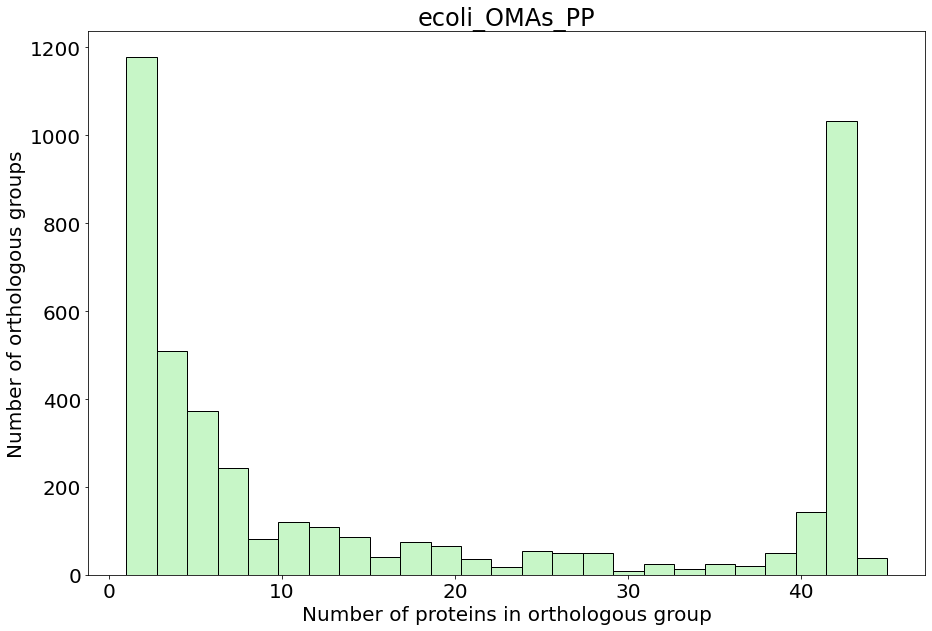

In [3]:
group = "ecoli_OMAs_PP"
print(group)
data_g, data_m, _ = get_group_data(group)
prot_count = data_g.groupby("og").agg({"prot_id": lambda x: x.nunique()})             # Count unique proteins in each OG
paralog_count = data_g.groupby("og").agg({"taxid": lambda x: x.size - x.nunique()})   # Count number of paralogs in each OG
taxid_count = data_g.groupby("og").agg({"taxid": lambda x: x.nunique()})              # Count number of strains in each OG

print("Total number of groups: ", data_g.og.nunique())
print("Groups with 1 protein -", (prot_count.query("prot_id == 1").size))
print("Groups with 43 proteins (core proteome) -", taxid_count.query("taxid == 43").size)
print("Groups with < 43 proteins (accessory proteome) -", taxid_count.query("taxid < 43").size)
print("Groups with > 43 proteins (paralogs included) -", prot_count.query("prot_id > 43").size)
print("Total number of paralogs -", paralog_count.taxid.sum())
print("Median of paralogs -", paralog_count.taxid.median())
print("Mean of paralogs -", paralog_count.taxid.mean())
print()

plt.rc("figure", figsize=(15, 10))
plt.rc("font", size=20)

sns.histplot(prot_count.prot_id, bins=25, alpha=0.5, color="lightgreen")
plt.xlabel("Number of proteins in orthologous group")
plt.ylabel("Number of orthologous groups")
plt.title(group)

## Proportion of proteins containing polyproline motifs

ecoli_OMAs_PP
Average number of polyproline motifs per protein - 1.2774489012633194
Average number of polyproline motifs per protein normalized to the sequence length - 0.315%



Text(0, 0.5, 'Number of groups')

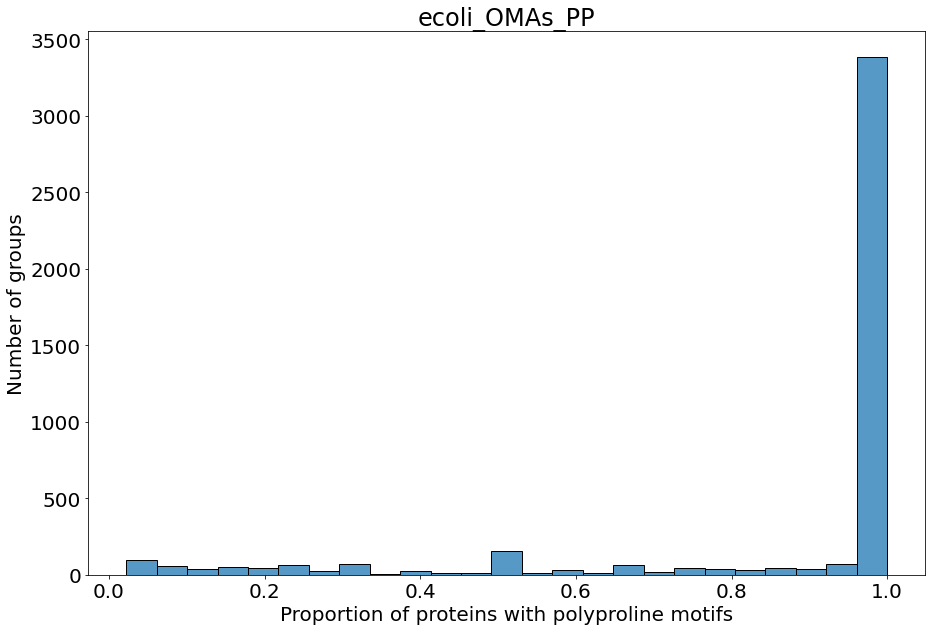

In [4]:
plt.rc("figure", figsize=(15, 10))
plt.rc("font", size=20)

data_g, data_m, data_p = get_group_data(group)
data = data_g.merge(data_m, on="prot_id")
data = data.merge(data_p, on="prot_id")
with_pp_count = data.groupby("og").agg({"seq": lambda x: sum(x != "NNNNN") / x.size})
pp_per_protein = data.groupby("prot_id").agg({"seq": lambda x: sum(x != "NNNNN"), "length": "mean"})
print(group)
print("Average number of polyproline motifs per protein -", pp_per_protein.seq.mean())
print("Average number of polyproline motifs per protein normalized to the sequence length - {:.3f}%".format(
    pp_per_protein.seq.mean() / pp_per_protein.length.mean() * 100))
print()


sns.histplot(with_pp_count.seq, bins=25)
plt.title(group)
plt.xlabel("Proportion of proteins with polyproline motifs")
plt.ylabel("Number of groups")

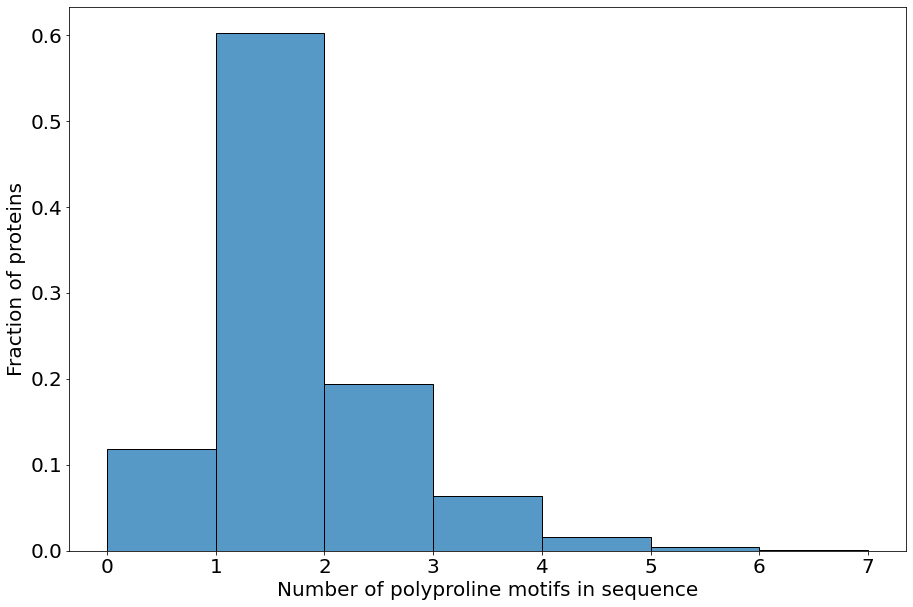

In [5]:
plt.rc("figure", figsize=(15, 10))
plt.rc("font", size=20)

sns.histplot(x="seq", data=pp_per_protein, bins=range(8), stat="probability")
plt.xlabel("Number of polyproline motifs in sequence", size=20)
plt.ylabel("Fraction of proteins", size=20)
_ = plt.xticks(range(8), range(8))

Text(0, 0.5, 'Fraction of polyproline motifs')

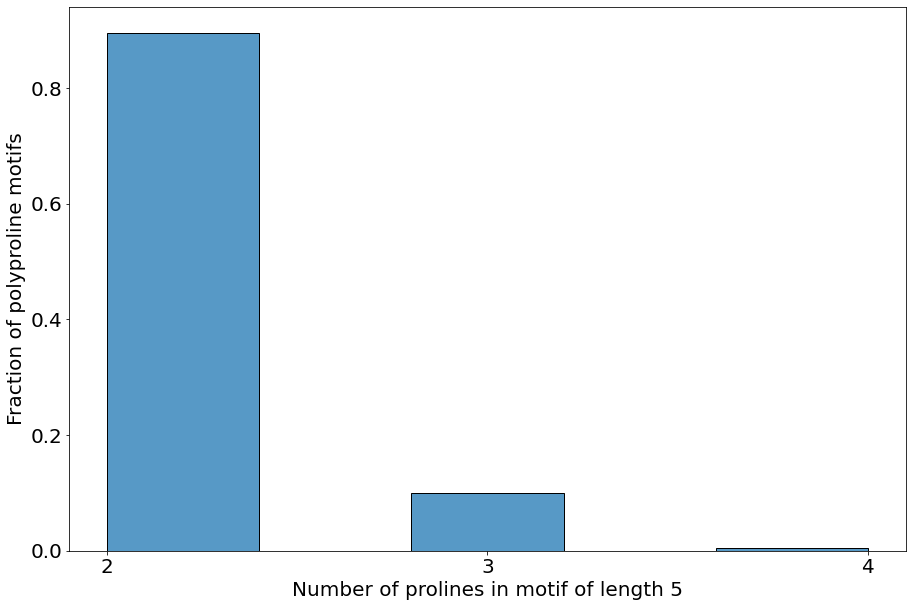

In [6]:
plt.rc("figure", figsize=(15, 10))
plt.rc("font", size=20)

p_count = data_m.seq.apply(lambda x: x.count("P"))
p_count = p_count[p_count > 0]
sns.histplot(p_count, stat="probability", bins=5)
plt.xticks(range(2, 5), range(2, 5))
plt.xlabel("Number of prolines in motif of length 5", size=20)
plt.ylabel("Fraction of polyproline motifs", size=20)

## Motif strength distribution

Text(0.5, 1.0, 'ecoli_OMAs_PP')

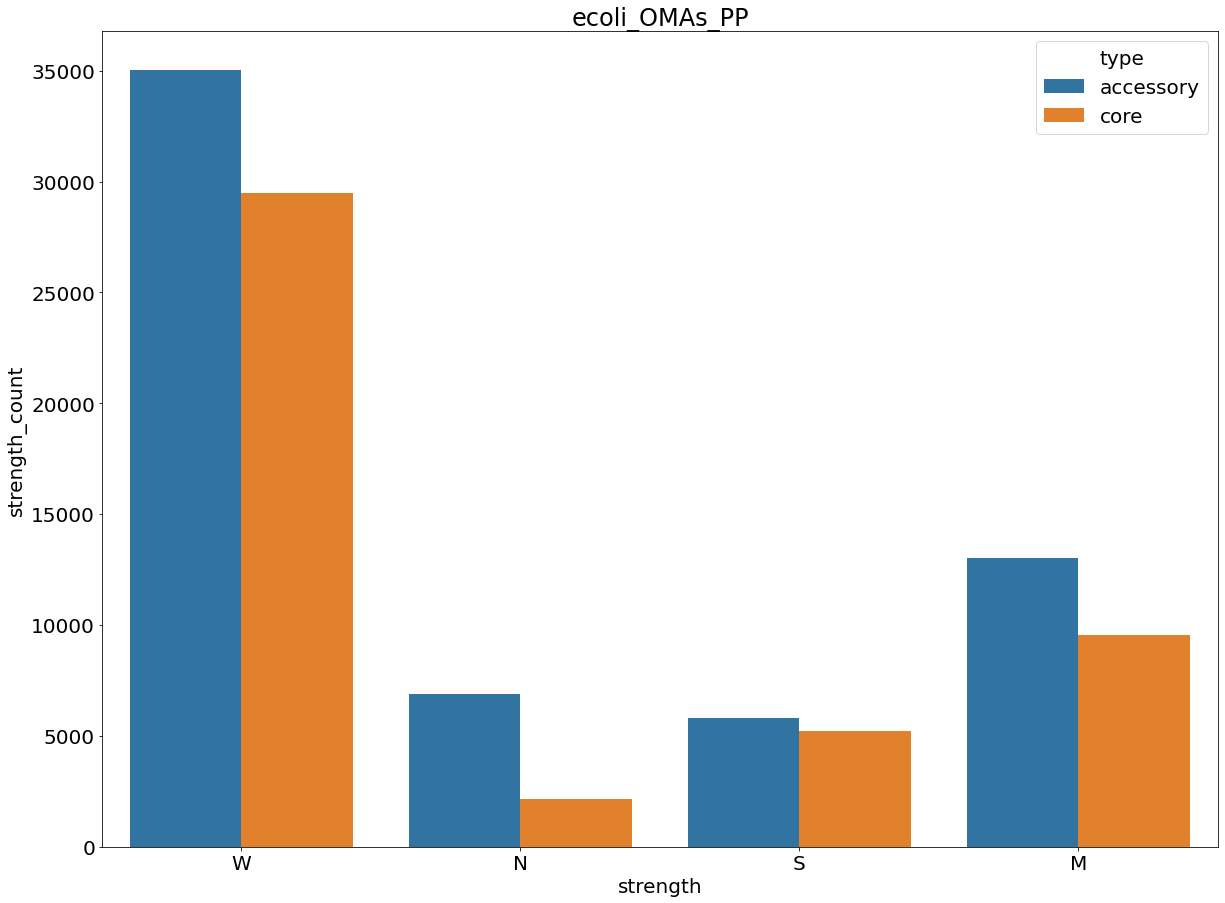

In [7]:
plt.rc("figure", figsize=(20, 15))
plt.rc("font", size=20)

data_g, data_m, data_p = get_group_data(group)
data = data_g.merge(data_m, on="prot_id")
core_proteome_groups = data_g.groupby("og").agg({"taxid": lambda x: x.nunique()}).query("taxid == 43")
accessory_proteome_groups = data_g.groupby("og").agg({"taxid": lambda x: x.nunique()}).query("taxid < 43")
accessory_proteome_groups.loc[:, "type"] = "accessory"
core_proteome_groups.loc[:, "type"] = "core"
data_types = data.merge(accessory_proteome_groups.append(core_proteome_groups).drop(columns=["taxid"]), on="og",
                        how="outer")
strength_count = data_types.groupby(["strength", "type"]).agg({"prot_id": "count"})
strength_count = strength_count.rename(columns={"prot_id": "strength_count"})
data_types = data_types.merge(strength_count, on=["strength", "type"], how="outer")

sns.barplot(x="strength", y="strength_count", hue="type", data=data_types, )
plt.title(group)

***N* is proteins without polyproline motifs**

# Pairwise alignment analysis

In [8]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import itertools
from scipy.stats import mannwhitneyu


plt.rc("figure", figsize=(25, 10))

In [9]:
def parse_conservation_data(series):
    """Given a series of specifically described substitution data.
    Example: A|1,G|3,P|10
    
    This means that in the corresponding alignment there were observed
    1 substitution P-A, 3 substitutions P-G and 10 substitutions P-P, which indicate
    absense of substitutions.
    Output is a series where values are number of substitution to amino acid in index"""
    all_subst = pd.Series(index=list("ACDEFGHIKLMNPQRSTVWYX-"), dtype=int)
    parsed_data = series.apply(lambda x: list(map(lambda y: (y.split("|")[0], int(y.split("|")[1])), x.split(","))))
    for substitutions in tqdm.tqdm_notebook(parsed_data):
        subst = pd.Series(index=list("ACDEFGHIKLMNPQRSTVWYX-"), dtype=int)
        for s in substitutions:
            subst[s[0]] += s[1]
        all_subst += subst
    return all_subst


def parse_single_subst_record(subst_str):
    """Returns a conservation of proline in a particular
    alignment using substitution data string"""
    all_subst = pd.Series(index=list("ACDEFGHIKLMNPQRSTVWYX-"), dtype=int)
    parsed_data = list(map(lambda y: (y.split("|")[0], int(y.split("|")[1])), subst_str.split(",")))
    for s in parsed_data:
        all_subst[s[0]] += s[1]
    return all_subst["P"] / all_subst.sum()


def get_all_aa_subst_distrib(series):
    """Count substitutions of proline to all amino acids like
    'parse_conservation_data' does with proline.
    Output is data frame with amino acids as columns and number of substitutions as value"""
    data = defaultdict(list)
    parsed_data = series.apply(lambda x: list(map(lambda y: (y.split("|")[0], int(y.split("|")[1])), x.split(","))))
    for substitutions in tqdm.tqdm_notebook(parsed_data):
        subst = pd.Series(index=list("ACDEFGHIKLMNPQRSTVWYX-"), dtype=int)
        for s in substitutions:
            subst[s[0]] += s[1]
        for aa, s in zip(subst.index, subst):
            data[aa].append(s)
    return pd.DataFrame(data)


def normalize_aa_subst(aa_subst_df):
    """Given a data frame with numbers of proline substitutions
    to each amino acid. Returns normalized values for each observation"""
    return aa_subst_df.div(aa_subst_df.sum(axis=1), axis="rows")


def assign_aa_data(data, aa_subst_df, n=50):
    """Takes averages of substitutions to all amino acids
    in groups of 'n" random proteins'.
    'data' is a data frame from where substitution information was taken,
    'aa_subst_df' is a result of applying 'get_all_aa_subst_distrib' to 'data'"""
    aa_subst_df = normalize_aa_subst(aa_subst_df) \
                             .assign(SEQUENCE_1=data.SEQUENCE_1,
                                     SEQUENCE_2=data.SEQUENCE_2) \
                             .groupby(["SEQUENCE_1", "SEQUENCE_2"]) \
                             .agg("mean") \
                             .sample(frac=1, random_state=42)
    new_group_labels = list(itertools.chain(*[itertools.repeat(i, n)
                                              for i in range(len(aa_subst_df) + n // n)]))
    data = aa_subst_df.assign(NEW_GROUP=new_group_labels[:len(aa_subst_df)])
    data = data.groupby("NEW_GROUP").agg("mean")
    aa_labels = list(itertools.chain(*[list(data.columns) for i in range(len(data))]))
    return pd.DataFrame({"VALUES": data.values.ravel(), "AA": aa_labels})

## Conservation of sigle and motif prolines

In [10]:
BASE_DIR = "output"

In [11]:
# Read and concatenate data produced by workers of substitution finding script
datas = []
for file in os.listdir(BASE_DIR):
    data = pd.read_table(os.path.join(BASE_DIR, file), header=None,
                         names=["ORTGROUP", "SEQUENCE_1", "SEQUENCE_2", "GROUP", "MOTIF_NUM", "TYPE", "EVENT", "SUBST"])
    datas.append(data)
data = pd.concat(datas, axis=0, ignore_index=True).dropna()

In [12]:
# Take subsets of interest
single_prolines_data = data.query("GROUP == 1").reset_index(drop=True)
motif_prolines_data = data.query("GROUP == 2").reset_index(drop=True)
insertions_motif_data = data.query("GROUP == 3").reset_index(drop=True)
motif_prolines_subst_data = data.query("GROUP == 4 and TYPE == 's'").reset_index(drop=True)
insertions_motif_subst_data = data.query("GROUP == 4 and TYPE == 'i'").reset_index(drop=True)

In [13]:
# Calculates number of proline substitutions for all amino acids (takes much time)
all_aa_subst_data_motif = get_all_aa_subst_distrib(motif_prolines_data.SUBST)
all_aa_subst_data_single = get_all_aa_subst_distrib(single_prolines_data.SUBST)

<ipython-input-9-25b54e024158>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for substitutions in tqdm.tqdm_notebook(parsed_data):


In [14]:
# Takes average substitution rate in groups of size 100 and converts data to long format
single_prolines_subst_data = assign_aa_data(single_prolines_data, all_aa_subst_data_single, n=100)
motif_prolines_subst_data = assign_aa_data(motif_prolines_data, all_aa_subst_data_motif, n=100)

In [15]:
# Save data to file
single_prolines_subst_data.to_csv("data/substitutions/single_prolines.csv")
motif_prolines_subst_data.to_csv("data/substitutions/motif_prolines.csv")

In [16]:
# Read data from file
single_prolines_subst_data = pd.read_csv("data/substitutions/single_prolines.csv").drop(columns=["Unnamed: 0"])
motif_prolines_subst_data = pd.read_csv("data/substitutions/motif_prolines.csv").drop(columns=["Unnamed: 0"])

In [17]:
plot_data = single_prolines_subst_data.assign(TYPE="SINGLE") \
                                      .append(motif_prolines_subst_data.assign(TYPE="MOTIF"))

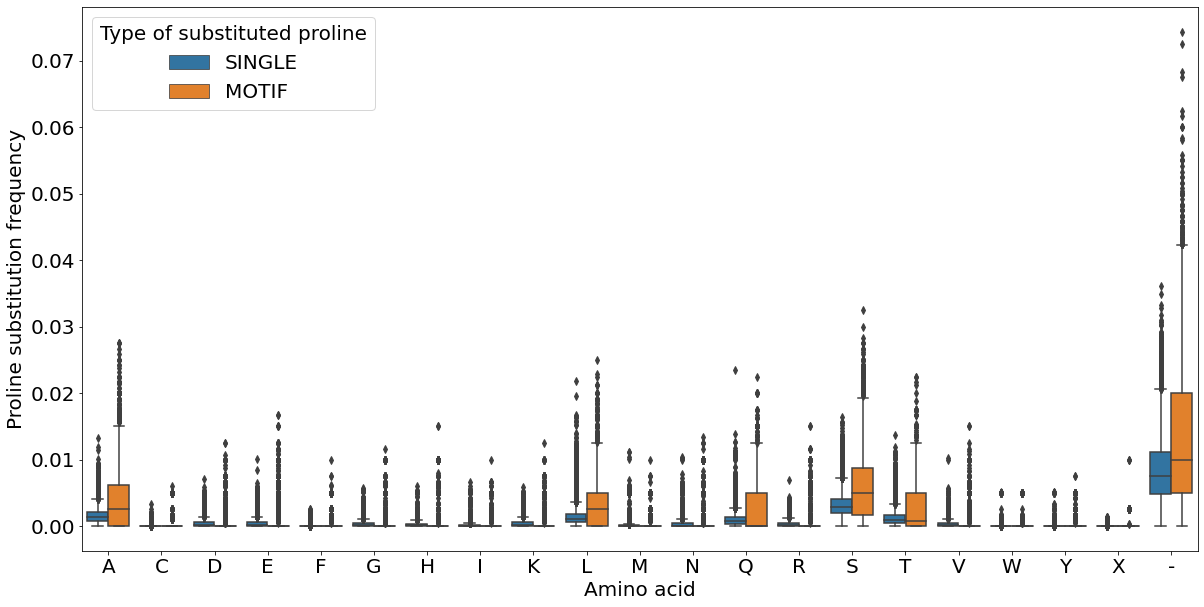

In [18]:
plt.rc("figure", figsize=(20, 10))
plt.rc("font", size=20)

sns.boxplot(x="AA", y="VALUES", hue="TYPE", data=plot_data.query("AA != 'P'"))
plt.ylabel("Proline substitution frequency", size=20)
plt.xlabel("Amino acid", size=20)
plt.legend(title="Type of substituted proline")

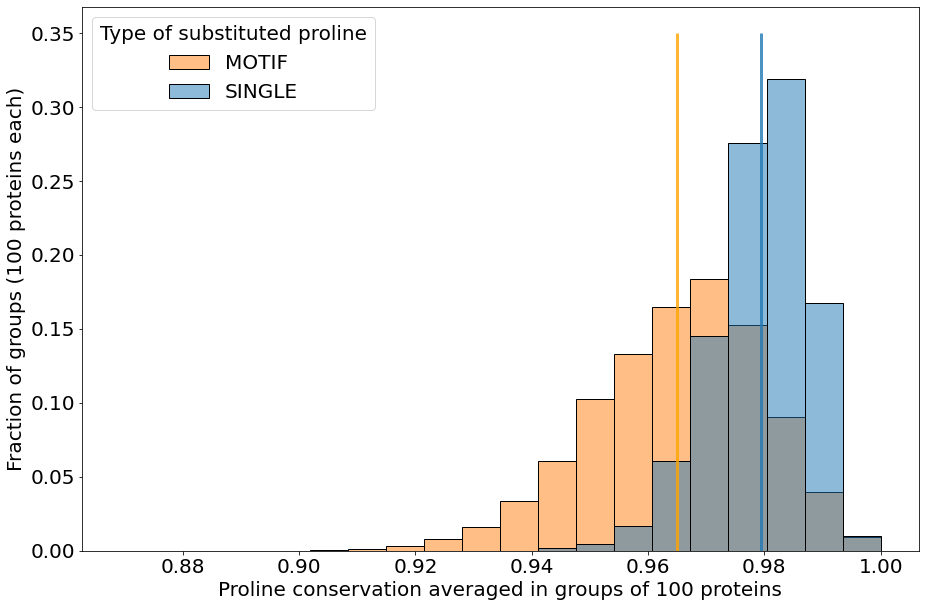

In [19]:
plt.rc("figure", figsize=(15, 10))
plt.rc("font", size=20)

sns.histplot(x="VALUES", hue="TYPE", data=plot_data.query("AA == 'P'"), bins=20, stat="probability", common_norm=False)
plt.legend(["MOTIF", "SINGLE"], title="Type of substituted proline")
plt.xlabel("Proline conservation averaged in groups of 100 proteins", size=20) 
plt.ylabel("Fraction of groups (100 proteins each)", size=20)
plt.vlines(plot_data.query("AA == 'P' and TYPE == 'SINGLE'").mean(), 0, 0.35, lw=3, alpha=0.8)
plt.vlines(plot_data.query("AA == 'P'  and TYPE == 'MOTIF'").mean(), 0, 0.35, lw=3, alpha=0.8, color="orange")

([<matplotlib.axis.XTick at 0x7f0b509d02e0>], [Text(1, 0, '')])

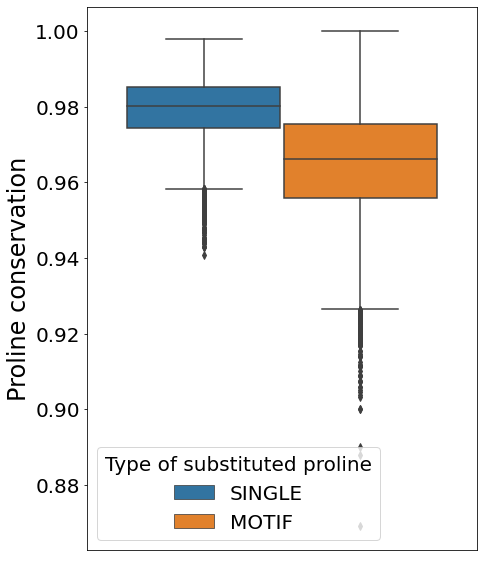

In [20]:
plt.rc("figure", figsize=(7, 10))
plt.rc("font", size=20)
sns.boxplot(x="AA", y="VALUES", hue="TYPE", data=plot_data.query("AA == 'P'"))
plt.legend(title="Type of substituted proline")
plt.xlabel("Amino-acid", size=24)
plt.xlabel("", size=24)
plt.ylabel("Proline conservation", size=24)
plt.xticks([1], [""])

## Conservation of prolines in core in accessory proteome

In [21]:
data_groups, _, _ = get_group_data("ecoli_OMAs_PP/")

In [22]:
# Extract core proteome groups from group_data
core_proteome_groups_str = data_groups.groupby("og").agg({"taxid": "count"}).query("taxid == 43").index.values
core_proteome_groups = set(map(int, core_proteome_groups_str))

In [23]:
# Make subsets of interest
single_prolines_core = data.query("GROUP == 1 and ORTGROUP in @core_proteome_groups").reset_index(drop=True)
single_prolines_acessory = data.query("GROUP == 1 and ORTGROUP not in @core_proteome_groups").reset_index(drop=True)
motif_prolines_core = data.query("GROUP == 2 and ORTGROUP in @core_proteome_groups").reset_index(drop=True)
motif_prolines_acessory = data.query("GROUP == 2 and ORTGROUP not in @core_proteome_groups").reset_index(drop=True)

In [24]:
# Calculates number of proline substitutions for all amino acids (takes much time)
all_aa_subst_data_motif_core = get_all_aa_subst_distrib(motif_prolines_core.SUBST)
all_aa_subst_data_single_core = get_all_aa_subst_distrib(single_prolines_core.SUBST)
all_aa_subst_data_motif_acessory = get_all_aa_subst_distrib(motif_prolines_acessory.SUBST)
all_aa_subst_data_single_acessory = get_all_aa_subst_distrib(single_prolines_acessory.SUBST)

<ipython-input-9-25b54e024158>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for substitutions in tqdm.tqdm_notebook(parsed_data):


In [26]:
single_prolines_core_subst_data = assign_aa_data(single_prolines_core, all_aa_subst_data_single_core, n=100)
motif_prolines_core_subst_data = assign_aa_data(motif_prolines_core, all_aa_subst_data_motif_core, n=100)
single_prolines_acessory_subst_data = assign_aa_data(single_prolines_acessory, all_aa_subst_data_single_acessory, n=100)
motif_prolines_acessory_subst_data = assign_aa_data(motif_prolines_acessory, all_aa_subst_data_motif_acessory, n=100)

In [27]:
single_prolines_core_subst_data.to_csv("data/substitutions/single_prolines_core_100.csv")
single_prolines_acessory_subst_data.to_csv("data/substitutions/single_prolines_accessory_100.csv")
motif_prolines_core_subst_data.to_csv("data/substitutions/motif_prolines_core_100.csv")
motif_prolines_acessory_subst_data.to_csv("data/substitutions/motif_prolines_accessory_100.csv")

In [28]:
single_prolines_core_subst_data = pd.read_csv("data/substitutions/single_prolines_core_100.csv", index_col=0)
single_prolines_acessory_subst_data = pd.read_csv("data/substitutions/single_prolines_accessory_100.csv", index_col=0)
motif_prolines_core_subst_data = pd.read_csv("data/substitutions/motif_prolines_core_100.csv", index_col=0)
motif_prolines_acessory_subst_data = pd.read_csv("data/substitutions/motif_prolines_accessory_100.csv", index_col=0)

In [29]:
single_prolines_core_subst_data

,VALUES,AA
0,0.000417,A
1,0.000000,C
2,0.000000,D
3,0.000000,E
4,0.000000,F
...,...,...
151179,0.000000,V
151180,0.000000,W
151181,0.000000,Y
151182,0.000000,X


In [30]:
plot_data = single_prolines_core_subst_data.assign(PROTEOME="CORE", TYPE="SINGLE").append(
            motif_prolines_core_subst_data.assign(PROTEOME="CORE", TYPE="MOTIF")).append(
            single_prolines_acessory_subst_data.assign(PROTEOME="ACCESSORY", TYPE="SINGLE")).append(
            motif_prolines_acessory_subst_data.assign(PROTEOME="ACCESSORY", TYPE="MOTIF"))

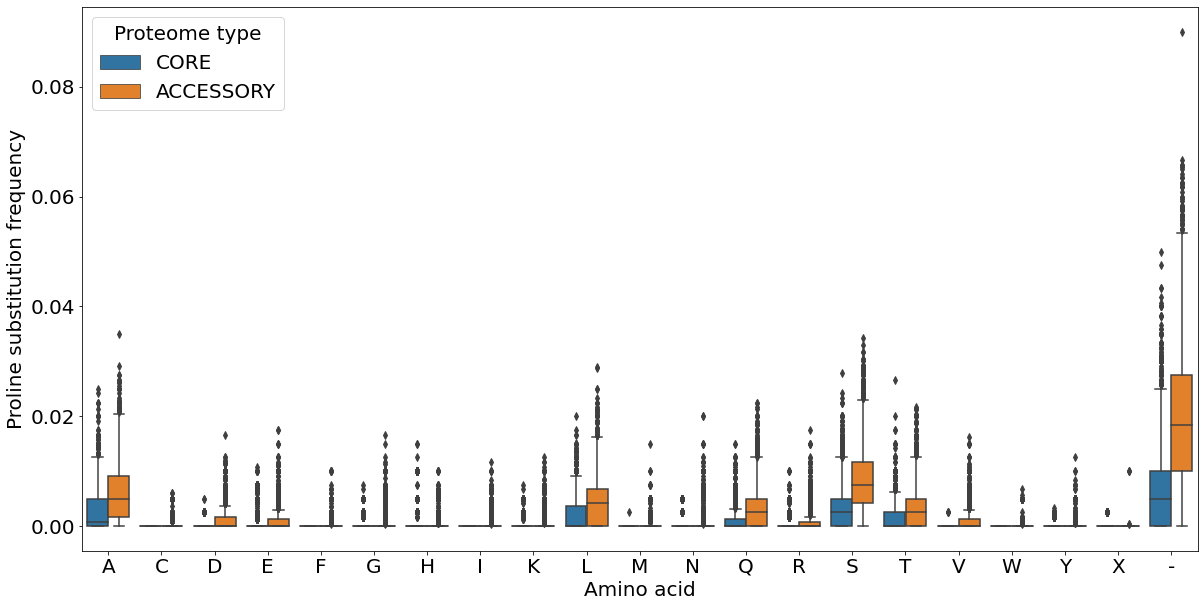

In [31]:
plt.rc("figure", figsize=(20, 10))
plt.rc("font", size=20)
sns.boxplot(x="AA", y="VALUES", hue="PROTEOME", data=plot_data.query("TYPE == 'MOTIF' and AA != 'P'"))
plt.ylabel("Proline substitution frequency", size=20)
plt.xlabel("Amino acid", size=20)
plt.legend(title="Proteome type")

Text(0, 0.5, 'Proline conservation')

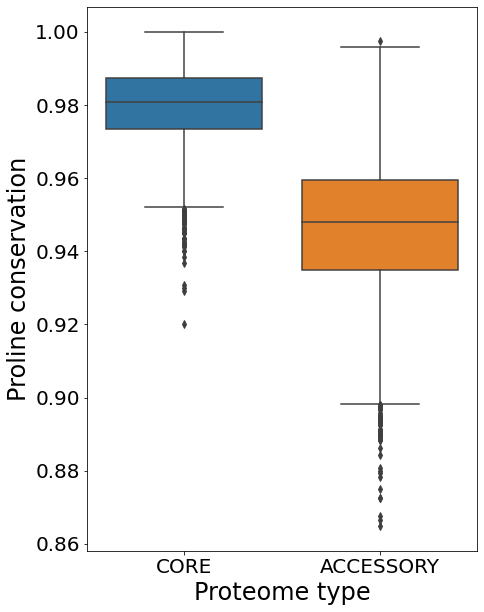

In [32]:
plt.rc("figure", figsize=(7, 10))
plt.rc("font", size=20)

sns.boxplot(x="PROTEOME", y="VALUES", data=plot_data.query("TYPE == 'MOTIF' and AA == 'P'"))

plt.xlabel("Amino-acid", size=24)
plt.xlabel("Proteome type", size=24)
plt.ylabel("Proline conservation", size=24)

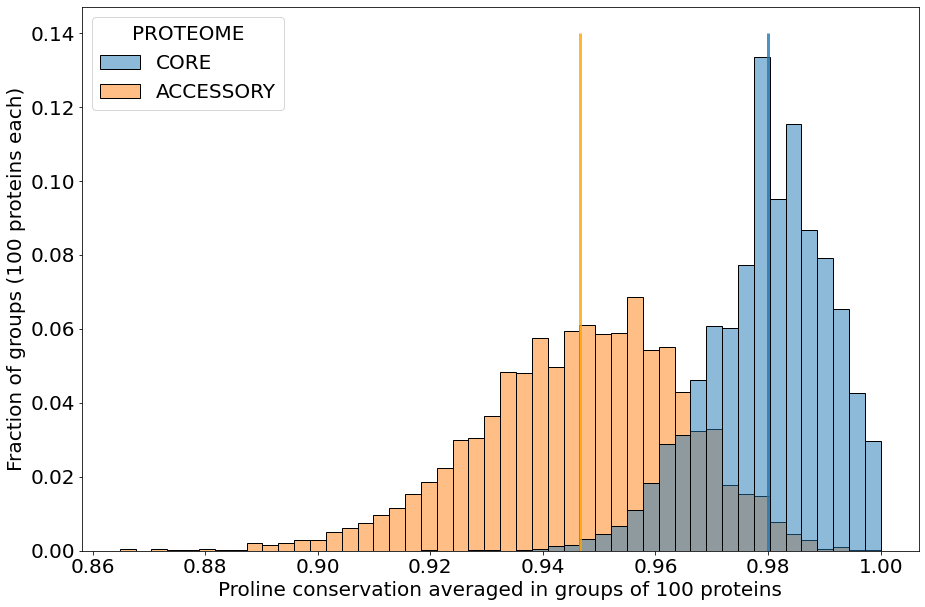

In [33]:
plt.rc("figure", figsize=(15, 10))
plt.rc("font", size=20)

sns.histplot(x="VALUES", hue="PROTEOME", data=plot_data.query("AA == 'P' and TYPE == 'MOTIF'"), stat="probability", common_norm=False)
plt.xlabel("Proline conservation averaged in groups of 100 proteins", size=20) 
plt.ylabel("Fraction of groups (100 proteins each)", size=20)
plt.vlines(plot_data.query("AA == 'P' and PROTEOME == 'CORE' and TYPE == 'MOTIF'").VALUES.mean(), 0, 0.14, lw=3, alpha=0.8)
plt.vlines(plot_data.query("AA == 'P' and PROTEOME == 'ACCESSORY' and TYPE == 'MOTIF'").VALUES.mean(), 0, 0.14, lw=3, alpha=0.8, color="orange")

In [34]:
for aa in motif_prolines_core_subst_data.AA.unique():
    stats = mannwhitneyu(motif_prolines_core_subst_data.query("AA == @aa").VALUES,
                         motif_prolines_acessory_subst_data.query("AA == @aa").VALUES, alternative="greater")
    print(aa, stats)

A MannwhitneyuResult(statistic=10074772.5, pvalue=1.0)
C MannwhitneyuResult(statistic=16679748.5, pvalue=1.0)
D MannwhitneyuResult(statistic=12850431.0, pvalue=1.0)
E MannwhitneyuResult(statistic=15249916.5, pvalue=1.0)
F MannwhitneyuResult(statistic=16076001.0, pvalue=1.0)
G MannwhitneyuResult(statistic=14649892.0, pvalue=1.0)
H MannwhitneyuResult(statistic=17898743.5, pvalue=3.1253120797612706e-07)
I MannwhitneyuResult(statistic=14966411.0, pvalue=1.0)
K MannwhitneyuResult(statistic=15628832.5, pvalue=1.0)
L MannwhitneyuResult(statistic=11416735.0, pvalue=1.0)
M MannwhitneyuResult(statistic=16108004.0, pvalue=1.0)
N MannwhitneyuResult(statistic=14400023.5, pvalue=1.0)
P MannwhitneyuResult(statistic=33024818.0, pvalue=0.0)
Q MannwhitneyuResult(statistic=10813185.5, pvalue=1.0)
R MannwhitneyuResult(statistic=13539763.0, pvalue=1.0)
S MannwhitneyuResult(statistic=8423170.5, pvalue=1.0)
T MannwhitneyuResult(statistic=10625566.0, pvalue=1.0)
V MannwhitneyuResult(statistic=12111088.0, pval

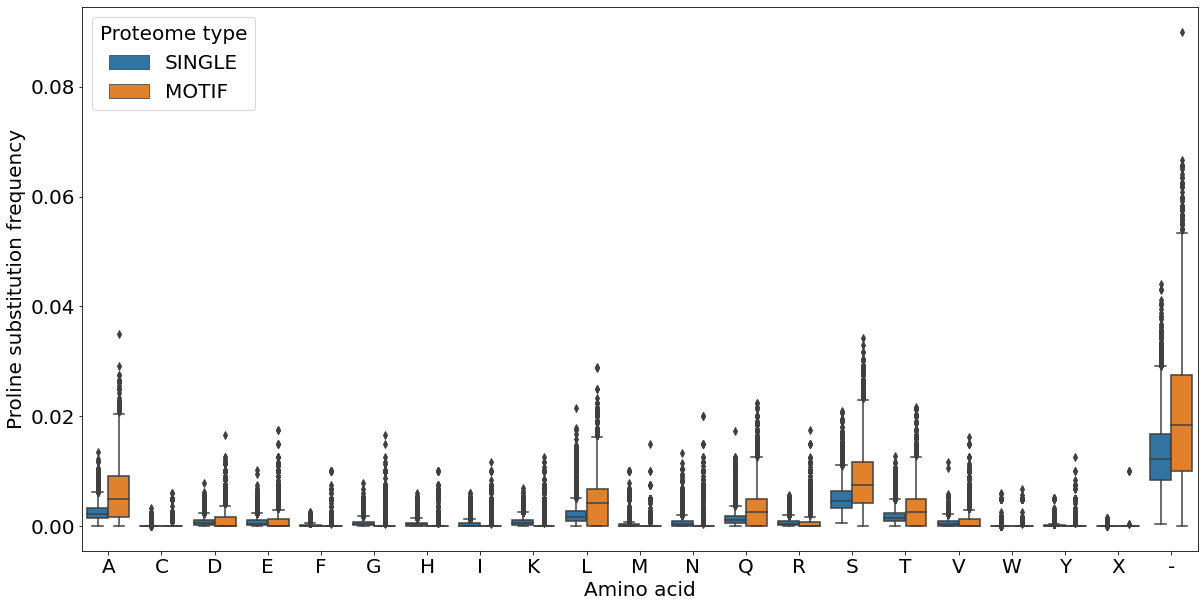

In [36]:
plt.rc("figure", figsize=(20, 10))
plt.rc("font", size=20)

sns.boxplot(x="AA", y="VALUES", hue="TYPE", data=plot_data.query("PROTEOME == 'ACCESSORY' and AA != 'P'"))
plt.ylabel("Proline substitution frequency", size=20)
plt.xlabel("Amino acid", size=20)
plt.legend(title="Proteome type")

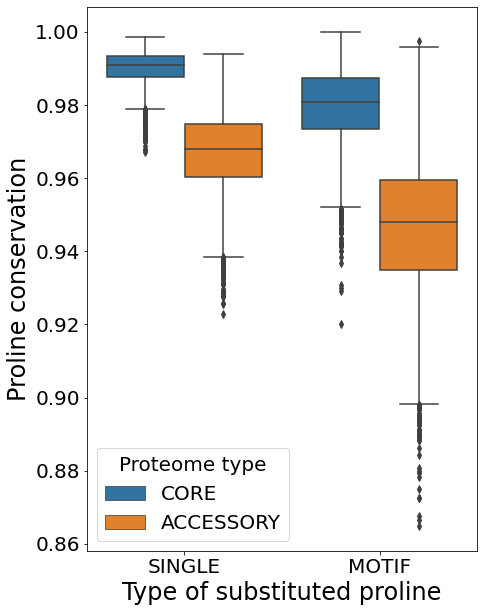

In [37]:
plt.rc("figure", figsize=(7, 10))
plt.rc("font", size=20)

sns.boxplot(x="TYPE", y="VALUES", hue="PROTEOME", data=plot_data.query("AA == 'P'"))

plt.xlabel("Type of substituted proline", size=24)
plt.ylabel("Proline conservation", size=24)
plt.legend(title="Proteome type")